In [1]:
import json

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : True})

RANDOM_SEED = 575
np.random.seed(RANDOM_SEED)

In [2]:
def get_control_frame_df(frame:str) -> pd.DataFrame:
    frame_df = verb_frames[[frame]]
    frame_df = frame_df[frame_df[frame] != 'x'].astype(int)
    frame_df[f'control_{frame}'] = np.random.choice(a=[1, 0], size=len(frame_df), p=[frame_probs[frame], 1-frame_probs[frame]])
    return frame_df

def run_control_task(
    frame_df: pd.DataFrame, 
    word_embeds: np.ndarray,
    model_type: str='linear',
    model_params: dict=None,
    train_prop: float=1
    ):

    frame = frame_df.columns[0]
    
    # Real Task
    indices_for_X = [VOCAB_TO_INDEX[verb] for verb in frame_df.index]
    cross_validation_iterator = StratifiedKFold(
        n_splits=4, shuffle=True, random_state=RANDOM_SEED
    )

    X = word_embeds[indices_for_X]
    y = frame_df[frame]
    results = []
    for fold, (train_idx, test_idx) in enumerate(
        cross_validation_iterator.split(X, y), start=1
    ):
        if train_prop < 1:
            train_idx = np.random.choice(train_idx, size=int(train_prop*len(train_idx)), replace=False)
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        verbs_test = [INDEX_TO_VOCAB[index] for index in test_idx]

        if model_type == 'linear':
            model = LogisticRegression(**model_params)
        elif model_type == 'sgd':
            model = SGDClassifier(**model_params)
        elif model_type == 'mlp':
            model = MLPClassifier(**model_params)
        else:
            raise ValueError(f'{model_type} is not a supported model type')
        
        model.fit(X_train, y_train)
        test_preds = model.predict(X_test)

        for verb, true_label, prediction in zip(verbs_test, y_test, test_preds):
            result_dict = {"verb": verb, "fold": fold}
            result_dict[f"{frame}_true"] = true_label
            result_dict[f"{frame}_predicted"] = prediction
            results.append(result_dict)
    
    predictions_df = pd.DataFrame.from_records(results)
    test_labels = predictions_df[f'{frame}_true']
    test_preds = predictions_df[f'{frame}_predicted']

    print(f'Results for {model_type} model')
    print('-----------------------')

    task_test_acc = accuracy_score(test_labels, test_preds)
    task_test_mcc = matthews_corrcoef(test_labels, test_preds)
    print(f'Task Test Accuracy: {task_test_acc}')
    print(f'Task Test MCC: {task_test_mcc}')

    # # Control Task
    X = word_embeds[indices_for_X]
    y = frame_df[f'control_{frame}']
    results = []
    for fold, (train_idx, test_idx) in enumerate(
        cross_validation_iterator.split(X, y), start=1
    ):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        verbs_test = [INDEX_TO_VOCAB[index] for index in test_idx]

        if model_type == 'linear':
            model = LogisticRegression(**model_params)
        elif model_type == 'sgd':
            model = SGDClassifier(**model_params)
        elif model_type == 'mlp':
            model = MLPClassifier(**model_params)
        else:
            raise ValueError(f'{model_type} is not a supported model type')
        
        model.fit(X_train, y_train)
        test_preds = model.predict(X_test)

        for verb, true_label, prediction in zip(verbs_test, y_test, test_preds):
            result_dict = {"verb": verb, "fold": fold}
            result_dict[f"{frame}_true"] = true_label
            result_dict[f"{frame}_predicted"] = prediction
            results.append(result_dict)
    
    predictions_df = pd.DataFrame.from_records(results)
    test_labels = predictions_df[f'{frame}_true']
    test_preds = predictions_df[f'{frame}_predicted']

    control_test_acc = accuracy_score(test_labels, test_preds)
    control_test_mcc = matthews_corrcoef(test_labels, test_preds)
    print(f'Control Test Accuracy: {control_test_acc}')
    print(f'Control Task Test MCC: {control_test_mcc}')

    acc_selectivity = task_test_acc - control_test_acc
    mcc_selectivity = task_test_mcc - max(control_test_mcc, 0)
    print(f'Selectivity (ACC): {acc_selectivity}')
    print(f'Selectivity (MCC): {mcc_selectivity}')

    return task_test_acc, acc_selectivity


In [3]:
with open('data/embeddings/bert-word-embeddings-lava-vocab.json', 'r') as fp:
    VOCAB_TO_INDEX = json.load(fp)
    INDEX_TO_VOCAB = INDEX_TO_VOCAB = {index: vocab for vocab, index in VOCAB_TO_INDEX.items()}

static_word_embeds = np.load('data/embeddings/bert-word-embeddings-lava.npy', allow_pickle=True)
layer_word_embeds = np.load('data/embeddings/bert-context-word-embeddings.npy', allow_pickle=True)[:, 7, :]

verb_frames = pd.read_csv('data/lava/verb_frames.csv', index_col='verb')
frame_probs = {}
for frame in verb_frames.columns:
    frame_df = verb_frames[[frame]]
    frame_df = frame_df[(frame_df[frame] != 'x')].astype(int)
    frame_prob = len(frame_df[frame_df[frame] == 1]) / len(frame_df)
    frame_probs[frame] = frame_prob

control_dfs = {frame: get_control_frame_df(frame) for frame in verb_frames.columns}

# Experiment on spray-load with frame
sl_with = control_dfs['with']

# Hyperparameters
hyperparams = {
    'hidden_dims': [20, 100, 300, 500, 768],
    'train_prop': [0.1, 0.3, 0.5, 0.7, 0.9],
    'l2': [1, 0.5, 0.2, 0.1, 0.01]
}

### Logistic Regression

In [4]:
records = []
for param, vals in hyperparams.items():
    for val in vals:
        print(f'Results for param: {param} with val: {val}')
        lr_model_params = {
            'random_state': RANDOM_SEED
        }
        # default vals
        hidden_dims = 768
        train_prop = 1
        l2 = 0

        if param == 'hidden_dims' and val != 768:
            hidden_dims = val
            SVD = TruncatedSVD(n_components=hidden_dims, random_state=RANDOM_SEED)
            svd_embeds = SVD.fit_transform(layer_word_embeds)
        elif param == 'train_prop':
            train_prop = val
        elif param == 'l2' and val > 0:
            l2 = val
            lr_model_params['penalty'] = 'l2'
            # C is inverse of regularization strength
            lr_model_params['C'] = 1 / l2 

        acc, acc_selectivity = run_control_task(
            sl_with,
            svd_embeds,
            model_type='linear',
            model_params=lr_model_params,
            train_prop = train_prop
        )
        print('\n')

        records.append({
            'model': 'linear',
            'hidden_dims': hidden_dims,
            'train_prop': train_prop,
            'l2': l2,
            'acc': acc,
            'acc_selectivity': acc_selectivity
        })

Results for param: hidden_dims with val: 20
Results for linear model
-----------------------
Task Test Accuracy: 0.9825072886297376
Task Test MCC: 0.9577951157526187
Control Test Accuracy: 0.673469387755102
Control Task Test MCC: 0.02334463009631124
Selectivity (ACC): 0.30903790087463556
Selectivity (MCC): 0.9344504856563074


Results for param: hidden_dims with val: 100
Results for linear model
-----------------------
Task Test Accuracy: 0.9854227405247813
Task Test MCC: 0.9650151599996456
Control Test Accuracy: 0.5860058309037901
Control Task Test MCC: -0.03901250289326703
Selectivity (ACC): 0.3994169096209912
Selectivity (MCC): 0.9650151599996456


Results for param: hidden_dims with val: 300
Results for linear model
-----------------------
Task Test Accuracy: 0.9854227405247813
Task Test MCC: 0.9650151599996456
Control Test Accuracy: 0.5568513119533528
Control Task Test MCC: -0.0921219918754184
Selectivity (ACC): 0.4285714285714285
Selectivity (MCC): 0.9650151599996456


Results fo

### MLP-1

In [5]:
for param, vals in hyperparams.items():
    for val in vals:
        print(f'Results for param: {param} with val: {val}')
        mlp1_model_params = {
            'random_state': RANDOM_SEED
        }
        # default vals
        hidden_dims = 768
        train_prop = 1
        l2 = 0

        if param == 'hidden_dims':
            hidden_dims = val
            mlp1_model_params['hidden_layer_sizes'] = hidden_dims
        elif param == 'train_prop':
            train_prop = val
        elif param == 'l2':
            l2 = val
            mlp1_model_params['alpha'] = l2

        acc, acc_selectivity = run_control_task(
            sl_with,
            layer_word_embeds,
            model_type='mlp',
            model_params=mlp1_model_params,
            train_prop = train_prop
        )
        print('\n')

        records.append({
            'model': 'mlp1',
            'hidden_dims': hidden_dims,
            'train_prop': train_prop,
            'l2': l2,
            'acc': acc,
            'acc_selectivity': acc_selectivity
        })

Results for param: hidden_dims with val: 20
Results for mlp model
-----------------------
Task Test Accuracy: 0.9825072886297376
Task Test MCC: 0.9577514714533178
Control Test Accuracy: 0.5714285714285714
Control Task Test MCC: -0.12981497223280225
Selectivity (ACC): 0.4110787172011662
Selectivity (MCC): 0.9577514714533178


Results for param: hidden_dims with val: 100
Results for mlp model
-----------------------
Task Test Accuracy: 0.9854227405247813
Task Test MCC: 0.9648393494695928
Control Test Accuracy: 0.5714285714285714
Control Task Test MCC: -0.11452533920810574
Selectivity (ACC): 0.4139941690962099
Selectivity (MCC): 0.9648393494695928


Results for param: hidden_dims with val: 300
Results for mlp model
-----------------------
Task Test Accuracy: 0.9854227405247813
Task Test MCC: 0.9648393494695928
Control Test Accuracy: 0.5860058309037901
Control Task Test MCC: -0.11785190375038952
Selectivity (ACC): 0.3994169096209912
Selectivity (MCC): 0.9648393494695928


Results for param

### MLP-2

In [6]:
for param, vals in hyperparams.items():
    for val in vals:
        print(f'Results for param: {param} with val: {val}')
        mlp2_model_params = {
            'random_state': RANDOM_SEED
        }
        # default vals
        hidden_dims = 768
        train_prop = 1
        l2 = 0

        if param == 'hidden_dims':
            hidden_dims = val
            mlp2_model_params['hidden_layer_sizes'] = (hidden_dims, hidden_dims)
        elif param == 'train_prop':
            train_prop = val
        elif param == 'l2':
            l2 = val
            mlp2_model_params['alpha'] = l2

        acc, acc_selectivity = run_control_task(
            sl_with,
            layer_word_embeds,
            model_type='mlp',
            model_params=mlp2_model_params,
            train_prop = train_prop
        )
        print('\n')

        records.append({
            'model': 'mlp2',
            'hidden_dims': hidden_dims,
            'train_prop': train_prop,
            'l2': l2,
            'acc': acc,
            'acc_selectivity': acc_selectivity
        })

Results for param: hidden_dims with val: 20
Results for mlp model
-----------------------
Task Test Accuracy: 0.9825072886297376
Task Test MCC: 0.9577514714533178
Control Test Accuracy: 0.5743440233236151
Control Task Test MCC: -0.08884011751822904
Selectivity (ACC): 0.40816326530612246
Selectivity (MCC): 0.9577514714533178


Results for param: hidden_dims with val: 100
Results for mlp model
-----------------------
Task Test Accuracy: 0.9912536443148688
Task Test MCC: 0.9789871508779665
Control Test Accuracy: 0.5860058309037901
Control Task Test MCC: -0.08693461822982008
Selectivity (ACC): 0.40524781341107874
Selectivity (MCC): 0.9789871508779665


Results for param: hidden_dims with val: 300
Results for mlp model
-----------------------
Task Test Accuracy: 0.9854227405247813
Task Test MCC: 0.9648393494695928
Control Test Accuracy: 0.5918367346938775
Control Task Test MCC: -0.10157847259645086
Selectivity (ACC): 0.39358600583090375
Selectivity (MCC): 0.9648393494695928


Results for pa

In [7]:
df = pd.DataFrame.from_records(records)
# default values
default_df = df[(df['hidden_dims'] == 768) & (df['train_prop'] == 1) & (df['l2'] == 0)].drop_duplicates()

rank_mccs = pd.concat((df[(df['hidden_dims'] != 768)], default_df))
prop_mccs = pd.concat((df[df['train_prop'] != 1.0], default_df))
l2_mccs = pd.concat((df[df['l2'] != 0], default_df))

In [10]:
default_df

,model,hidden_dims,train_prop,l2,acc,acc_selectivity
4,linear,768,1.0,0.0,0.985423,0.419825
19,mlp1,768,1.0,0.0,0.985423,0.396501
34,mlp2,768,1.0,0.0,0.988338,0.396501


In [42]:
best_acc = rank_mccs.groupby('model')[['hidden_dims', 'acc_selectivity']].max().acc_selectivity
best_rank = rank_mccs[rank_mccs.acc_selectivity.isin(best_acc)]

In [35]:
best_acc = prop_mccs.groupby('model')[['train_prop', 'acc_selectivity']].max().acc_selectivity
best_prop = prop_mccs[prop_mccs.acc_selectivity.isin(best_acc)].iloc[[2, 4, 5]]
best_prop

,model,hidden_dims,train_prop,l2,acc,acc_selectivity
9,linear,768,0.9,0.0,0.988338,0.422741
24,mlp1,768,0.9,0.0,0.982507,0.411079
39,mlp2,768,0.9,0.0,0.985423,0.413994


In [40]:
best_acc = l2_mccs.groupby('model')[['l2', 'acc_selectivity']].max().acc_selectivity
best_l2 = l2_mccs[l2_mccs.acc_selectivity.isin(best_acc)]
best_l2

,model,hidden_dims,train_prop,l2,acc,acc_selectivity
13,linear,768,1.0,0.1,0.985423,0.431487
25,mlp1,768,1.0,1.0,0.988338,0.419825
40,mlp2,768,1.0,1.0,0.988338,0.419825


In [75]:
best_models = pd.concat((default_df, best_rank, best_prop, best_l2), axis=0)
best_models.columns = ['Model', 'Hidden Dimensions (k)', 'Training Proportion (p)', 'L2 Regularization',
    'Accuracy', 'Selectivity']
best_models['Model'] = ['Linear', 'MLP-1', 'MLP-2']*4
best_models = best_models.round(3)
print(best_models.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
 Model &  Hidden Dimensions (k) &  Training Proportion (p) &  L2 Regularization &  Accuracy &  Selectivity \\
\midrule
Linear &                    768 &                      1.0 &                0.0 &     0.985 &        0.420 \\
 MLP-1 &                    768 &                      1.0 &                0.0 &     0.985 &        0.397 \\
 MLP-2 &                    768 &                      1.0 &                0.0 &     0.988 &        0.397 \\
Linear &                    300 &                      1.0 &                0.0 &     0.985 &        0.429 \\
 MLP-1 &                    100 &                      1.0 &                0.0 &     0.985 &        0.414 \\
 MLP-2 &                     20 &                      1.0 &                0.0 &     0.983 &        0.408 \\
Linear &                    768 &                      0.9 &                0.0 &     0.988 &        0.423 \\
 MLP-1 &                    768 &                      0.9 &                0.

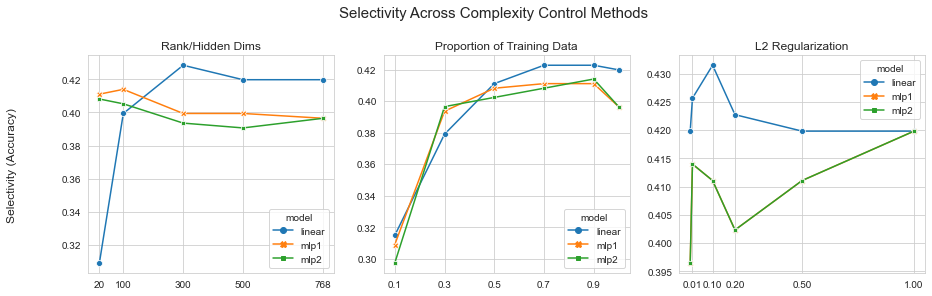

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.supylabel('Selectivity (Accuracy)', x=0.05, fontsize=12)
sup_title = fig.suptitle('Selectivity Across Complexity Control Methods', y=1.05, fontsize=15)

sns.lineplot(
    rank_mccs['hidden_dims'], rank_mccs['acc_selectivity'], hue=rank_mccs['model'], style=rank_mccs['model'],
    markers=True, dashes=False, ax=axs[0]
)
axs[0].set_xlabel('')
axs[0].set_xticks(hyperparams['hidden_dims'])
axs[0].set_ylabel('')
axs[0].set_title('Rank/Hidden Dims')

sns.lineplot(
    prop_mccs['train_prop'], prop_mccs['acc_selectivity'], hue=prop_mccs['model'], style=prop_mccs['model'],
    markers=True, dashes=False, ax=axs[1]
)
axs[1].set_xlabel('')
axs[1].set_xticks(hyperparams['train_prop'])
axs[1].set_ylabel('')
axs[1].set_title('Proportion of Training Data')

sns.lineplot(
    l2_mccs['l2'], l2_mccs['acc_selectivity'], hue=l2_mccs['model'], style=l2_mccs['model'],
    markers=True, dashes=False, ax=axs[2]
)
axs[2].set_title('L2 Regularization')
axs[2].set_xlabel('')
axs[2].set_xticks([0.01, 0.1, 0.2, 0.5, 1.0])
axs[2].set_ylabel('')

plt.savefig(transparent=False, facecolor='white', fname='selectivity.png', 
    bbox_inches='tight',bbox_extra_artists=[sup_title], dpi=1200)

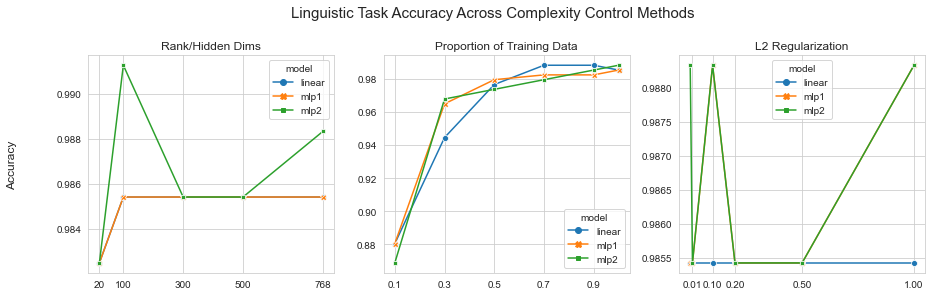

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
fig.supylabel('Accuracy', x=0.05, fontsize=12)
sup_title = fig.suptitle('Linguistic Task Accuracy Across Complexity Control Methods', y=1.05, fontsize=15)

sns.lineplot(
    rank_mccs['hidden_dims'], rank_mccs['acc'], hue=rank_mccs['model'], style=rank_mccs['model'],
    markers=True, dashes=False, ax=axs[0]
)
axs[0].set_xlabel('')
axs[0].set_xticks(hyperparams['hidden_dims'])
axs[0].set_ylabel('')
axs[0].set_title('Rank/Hidden Dims')

sns.lineplot(
    prop_mccs['train_prop'], prop_mccs['acc'], hue=prop_mccs['model'], style=prop_mccs['model'],
    markers=True, dashes=False, ax=axs[1]
)
axs[1].set_xlabel('')
axs[1].set_xticks(hyperparams['train_prop'])
axs[1].set_ylabel('')
axs[1].set_title('Proportion of Training Data')

sns.lineplot(
    l2_mccs['l2'], l2_mccs['acc'], hue=l2_mccs['model'], style=l2_mccs['model'],
    markers=True, dashes=False, ax=axs[2]
)
axs[2].set_title('L2 Regularization')
axs[2].set_xlabel('')
axs[2].set_xticks([0.01, 0.1, 0.2, 0.5, 1.0])
axs[2].set_ylabel('')

plt.savefig(transparent=False, facecolor='white', fname='accuracy.png',
bbox_inches='tight',bbox_extra_artists=[sup_title], dpi=1200)